In [75]:
import sys
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.stats import norm

sys.path.insert(0,'..')
from src.black_scholes import BlackScholes
from src.stochastic_process import wienerprocess
from src.monte_carlo import MLMC

In [288]:
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Pricing a European basket call

In this notebook we will consider a European basket call option, that is we have several correlated underylings. The $d$-dimensional SDE generating the geometric Brownian motion (GBM) is given by

$$
dS(t) = \mu S(t) dt + \sigma S(t) d W(t),
$$

with initial value $S(0) = S_0 \in \mathbb{R}^d$, drift $\mu \in \mathbb{R}$, and volatilties $\sigma = (\sigma_1, \ldots, \sigma_d) \in \mathbb{R}^d_{\geq 0}$. The GBM is thus a vector of unknowns

$$
S(t) = (S_1(t), \ldots, S_d(t)) \in \mathbb{R}^d,
$$

and the Wiener processes

$$
W(t) = (W_1(t), \ldots, W_d(t)) \in \mathbb{R}^d,
$$

are correlated with with the correlation matrix $\Sigma \in \mathbb{R}^{d \times d}$. The payoff funtion for a European basket call is based on a weighted average of the underylgings, that is

$$
P = (c ^\top S - K)^+,
$$

where $c \in \mathbb{R}^d$ denotes the weight vector and $K \geq 0$ the strike price.

## Basket option parameters

Let's fix some parameters and choose $d = 5$ underlyings, an even weight vector $c = (1/5, \ldots, 1/5) \in \mathbb{R}^d$, and volatilities $\sigma = (6.50, 4.47, 8.52, 6.02, 8.95) \in \mathbb{R}^d$ in percent. The volatilies and the following correlation matrix are  [exemplary historic data](https://www.portfoliovisualizer.com/asset-correlations?s=y&symbols=AAPL+AMZN+GOOG+META+MSFT&timePeriod=2&tradingDays=60&months=36) for the big 5 tech companies. Thus, the correlation matrix shows significant dependencies.

|          | AAPL | AMZN | GOOG | META | MSFT |
|----------|------|------|------|------|------|
| **AAPL** | 1.0  | 0.70 | 0.48 | 0.69 | 0.50 |
| **AMZN** | 0.70 | 1.0  | 0.39 | 0.91 | 0.51 |
| **GOOG** | 0.48 | 0.39 | 1.0  | 0.51 | 0.91 |
| **META** | 0.69 | 0.91 | 0.51 | 1.0  | 0.73 |
| **MSFT** | 0.50 | 0.51 | 0.91 | 0.73 | 1.0  |

In [327]:
d = 5
c = 1 / d * np.ones(d)

In [328]:
Sigma = np.array(
    [
        [1.0, 0.70, 0.48, 0.69, 0.50],
        [0.70, 1.0, 0.39, 0.91, 0.51],
        [0.48, 0.39, 1.0, 0.51, 0.91],
        [0.69, 0.91, 0.51, 1.0, 0.73],
        [0.50, 0.51, 0.91, 0.73, 1.0],
    ]
)
L = np.linalg.cholesky(Sigma).T

We will plot $5$ Wiener paths with the correlation dictated by the historic correlation matrix $\Sigma$ above.

In [329]:
T = 1
N = 2 ** 9
W = wienerprocess(1, N, d).reshape(N + 1, 1, d).squeeze()

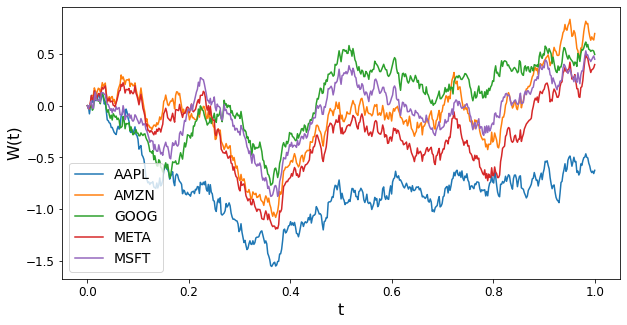

In [330]:
fig = plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, N + 1), W @ L, label=["AAPL", "AMZN", "GOOG", "META", "MSFT"])
plt.xlabel(r"t")
plt.ylabel(r"W(t)")
plt.legend();

**Note** that these are not underlyings itself, but only the Wiener paths producing the randomness. The following data for the initial value $S_0 \in \mathbb{R}^d$ is also historic data representing the stock price as of January 4th of 2021, repsectively. The strike $K = 1000$ and the risk-free rate $r=2.5\%$ is choosen randomly.

In [346]:
option_params = {
    "s0": np.array([129.41, 2596.50, 1728.24, 218.30, 217.69]),
    "K": 1000,
    "r": 0.025,
    "sigma": np.array([6.50, 4.47, 8.52, 6.02, 8.95]) / 100,
    "T": 1,
    "c": np.full(d, 1/d),
    "L": L,
    "option_type": 'basket_call',
}

In [345]:
M = 2
eps = .01

MLMC_estimator = MLMC(M, eps)
val, sample_sizes = MLMC_estimator.fit(option_params, solver="EM")
print(f"Basket option value: {val:.3f}")
print(f"Used sample sizes: {sample_sizes}")

Basket option value: 21.354
Used sample sizes: [25928867, 823548, 408053, 191939, 82933, 42583, 22545, 12910]
